<a href="https://colab.research.google.com/github/Daniel-Wait/SKRIPSIE_workbooks/blob/master/SKRIPSIE_codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
"""
DB WAIT
20887507

"""
%matplotlib inline
%load_ext autoreload
%autoreload 2
import math
import numpy as np
from matplotlib import pylab as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Import different modules for using with the notebook
from IPython.display import display
from IPython.display import Image
from IPython.display import HTML

#A helper-function to setup a proper plot
def setup_plot(title, y_label='', x_label='', newfig=True):
  if newfig:
    plt.figure()
  plt.margins(*(plt.array(plt.margins())+0.05))
  plt.title(title)
  plt.ylabel(y_label)
  plt.xlabel(x_label)


def fsk(bitseq, spb, f_0, f_1, F):
  T = 1/F  
  nb = bitseq.shape[0]
  num = np.array(range(0, spb))
  mn = np.zeros(shape = (spb*nb,))
  mn_len = np.array(range(0, mn.shape[0]))
  
  for i in range(0, nb):
    if (bitseq[i] == 1): 
      bit = np.sin(2*f_1*np.pi*num*T)
    if (bitseq[i] == 0):
      bit = np.sin(2*f_0*np.pi*num*T)
    mn[i*spb:(i+1)*spb] = bit

  #setup_plot("Modulated Signal")
  #plt.plot(mn, 'c')
  #plt.show()
  
  return mn

def pollute(bitseq, len_f, len_b, spb, f_0, f_1, F, gain, timeshift, noise_stddev):
  T = 1/F  
  nb = bitseq.shape[0]
  num = np.array(range(0, spb)) 
  rn = np.zeros(shape = (spb*nb,))
  phase1 = 2*np.pi*f_1*timeshift
  phase0 = 2*np.pi*f_0*timeshift

  for i in range(0, nb):
    if (bitseq[i] == 1): 
      bit = np.sin(2*f_1*np.pi*num*T + phase1)
    if (bitseq[i] == 0):
      bit = np.sin(2*f_0*np.pi*num*T + phase0)
    rn[i*spb:(i+1)*spb] = bit
  
  rn = np.insert(rn, 0, np.zeros(shape = (len_f,)) )
  rn = np.append(rn, np.zeros(shape = (len_b,)) )
  wn = np.random.normal(loc=0.0, scale=noise_stddev, size=(nb*spb + len_f + len_b,))
  rn = gain*rn + wn
  
  #setup_plot("Received Signal")
  #plt.plot(rn, 'm')
  #plt.show()
  
  return rn

def chirp_fsk(bitseq, spb, f_0, f_1, F, df):
  T = 1/F  
  nb = bitseq.shape[0]
  num = np.array(range(0, spb))
  mn = np.zeros(shape = (spb*nb,))
  mn_len = np.array(range(0, mn.shape[0]))
  chirp = np.array(range(0,spb))*(df/spb)

  #print(chirp+f_1)

  for i in range(0, nb):
    if (bitseq[i] == 1): 
      bit = np.sin(2*(f_1+chirp)*np.pi*num*T)
    if (bitseq[i] == 0):
      bit = np.sin(2*(f_0-chirp)*np.pi*num*T)
    mn[i*spb:(i+1)*spb] = bit
  
  #setup_plot("Modulated Signal")
  #plt.plot(mn, 'c')
  #plt.show()

  return mn

def chirp_pollute(bitseq, len_f, len_b, spb, f_0, f_1, F, gain, timeshift, noise_stddev, df):
  T = 1/F  
  nb = bitseq.shape[0]
  num = np.array(range(0, spb)) 
  rn = np.zeros(shape = (spb*nb,))
  phase1 = 2*np.pi*f_1*timeshift
  phase0 = 2*np.pi*f_0*timeshift
  chirp = np.array(range(0,spb))*(df/spb)

  for i in range(0, nb):
    if (bitseq[i] == 1): 
      bit = np.sin(2*(f_1+chirp)*np.pi*num*T + phase1)
    if (bitseq[i] == 0):
      bit = np.sin(2*(f_0-chirp)*np.pi*num*T + phase0)
    rn[i*spb:(i+1)*spb] = bit
  
  rn = np.insert(rn, 0, np.zeros(shape = (len_f,)) )
  rn = np.append(rn, np.zeros(shape = (len_b,)) )
  wn = np.random.normal(loc=0.0, scale=noise_stddev, size=(nb*spb + len_f + len_b,))
  rn = gain*rn + wn
  
  return rn


def downsample(input, len, factor):
  output = input[:len:factor]
  return output


def xnor_autocorr(x):
  N = x.shape[0]
  y = x
  rxx = np.zeros(shape = (N,), dtype = np.float32 )

  for i in range(0,N):
    #rxx[i+N-1] = np.sum( x[0:N-i]*y[i:N] )
    for n in range(0, N-i):
      if (x[n] == y[n+i]):
        rxx[i] = rxx[i] + 1

  rxx = np.insert(rxx, 0, np.flip(rxx[1:N]))
  return rxx


def xnor_xcorr(x, y):
  N = x.shape[0]
  rxx = np.zeros(shape = (2*N-1,), dtype = np.float32 )
  r2 = np.zeros(shape = (2*N-1,), dtype = np.float32 )
  
  for i in range(0,N):
    #rxx[i+N-1] = np.sum( y[0:N-i]*x[i:N] )
    for n in range(0, N-i):
      if (y[n] == x[n+i]):
        rxx[i+N-1] = rxx[i+N-1] + 1

  for i in range(0,N):
      #rxx[N-i-1] = np.sum( x[0:N-i]*y[i:N] )
      for n in range(0, N-i):
        if (x[n] == y[n+i]):
          rxx[N-i-1] = rxx[N-i-1] + 1
  rxx[N-1] = rxx[N-1]/2
  """

  for i in range(0,N):
    for n in range(0, N-i):
      if (y[n] == x[n+i]):
        r1[i+N-1] = r1[i+N-1] + 1


  
  for n in range(0,i):
    rxx[i] = rxx[i] + x[n]*y[N-i+n]
    
  """
      

      
  """for i in range(0,N):
      for n in range(0, N-i):
        if (x[n] == y[n+i]):
          rxx[N-1-i] = rxx[i] + 1"""

  """for i in range(0,N):
      #rxx[N-i-1] = np.sum( x[0:N-i]*y[i:N] )
      for n in range(0, N-i):
        if (x[n] == y[n+i]):
          rxx[N-i-1] = rxx[i] + 1"""

  return rxx


def show_corr_outs(bitseq, f0, f1, fs, samps, dsamp, delta_f):
  print(bitseq.shape[0])
  rbb = np.correlate(bitseq, bitseq, mode = "full")
  #print(rbb.shape)
  #print(rbb)
  setup_plot("1/0 Binary xCorr")
  plt.plot(rbb)
  plt.show()

  rrr = xnor_autocorr(bitseq)
  setup_plot("CUSTOM Binary xCorr")
  plt.plot(rrr)
  plt.show()

  #STANDARD FSK
  tx = fsk(bitseq = bitseq, spb = samps, f_0 = f0, f_1 = f1, F = fs)
  tx = downsample(tx, bitseq.shape[0]*samps, dsamp)

  rx = pollute(bitseq=bitseq, len_f = 0, len_b = 0, spb = samps, f_0 = f0, f_1 = f1, F = fs, gain = 1, timeshift = 0, noise_stddev = 0)
  rx = downsample(rx, bitseq.shape[0]*samps, dsamp)

  rtr = np.correlate(rx, tx, mode = "full")
  setup_plot("Standard FSK Modulated xCorr")
  plt.plot(rtr)
  plt.show()

  #CHIRPED FSK
  ctx = chirp_fsk(bitseq = bitseq, spb = samps, f_0 = f0, f_1 = f1, F = fs, df = delta_f*4)
  ctx = downsample(ctx, bitseq.shape[0]*samps, dsamp)

  crx = chirp_pollute(bitseq=bitseq, len_f = 0, len_b = 0, spb = samps, f_0 = f0, f_1 = f1, F = fs, gain = 1, timeshift = 0, noise_stddev = 0, df = delta_f*4)
  crx = downsample(crx, bitseq.shape[0]*samps, dsamp)

  crtr = np.correlate(crx, ctx, mode = "full")
  setup_plot("Chirped FSK ModulatedxCorr")
  plt.plot(crtr)
  plt.show()
  """
  #CONFUSION
  wrtr = np.correlate(rx, ctx, mode = "full")
  setup_plot("xCorr of Chirped and Standard FSK (same message)")
  plt.plot(wrtr)
  plt.show()

  ectx = chirp_fsk(bitseq = bitseq, spb = samps, f_0 = f0, f_1 = f1, F = fs, df = delta_f*4/2)
  ectx = downsample(ectx, bitseq.shape[0]*samps, dsamp)

  ertr = np.correlate(rx, ectx, mode = "full")
  setup_plot("xCorr of Different Sweep widths")
  plt.plot(ertr)
  plt.show()
  """

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#https://stackoverflow.com/questions/22227595/convert-integer-to-binary-array-with-suitable-padding

def vec_bin_array(arr, m):
    """
    Arguments: 
    arr: Numpy array of positive integers
    m: Number of bits of each integer to retain

    Returns a copy of arr with every element replaced with a bit vector.
    Bits encoded as int8's.
    """
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(m))
    strs = to_str_func(arr)
    ret = np.zeros(list(arr.shape) + [m], dtype=np.int8)
    for bit_ix in range(0, m):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        ret[...,bit_ix] = fetch_bit_func(strs).astype("int8")

    return ret 

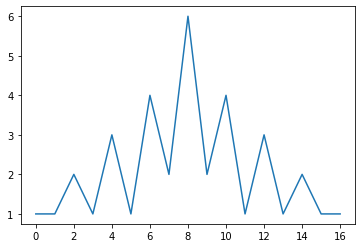

In [133]:
x = np.array([1,0,1,0,1,0,1,1,1])
y = np.array([1,0,1,0,1,0,1,1,1])

rxy = np.correlate(x, y, mode = "full")
plt.plot(rxy)
plt.show()

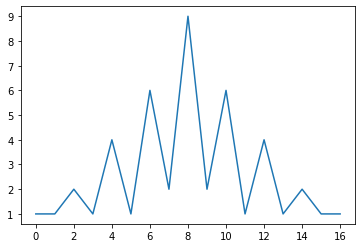

In [134]:
rxy = xnor_autocorr(x)
plt.plot(rxy)
plt.show()

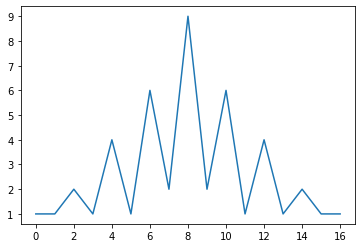

6.0


In [135]:
rxy = xnor_xcorr(x, y)

plt.plot(rxy)
plt.show()

print(rxy[6])

#Initialize Variables

In [6]:
fs = 44100
Ts = 1/fs

Tb = 20e-3
samps = int(Tb*fs) 
print(samps)

n = 1
delta_f = n/(2*Tb)
print(delta_f)

#f1 = delta_f*10
f1 = delta_f*32
f0 = delta_f*16
print(f0, f1)

dsamp = 2
blocks = 6
L = 1024
N = L*2
print(dsamp, blocks, L, N)

882
25.0
400.0 800.0
2 6 1024 2048


#Maximum of FSK Correlation

*For N-bit message and L samples/bit*

**Result:**

  rxx_max = N*L/2

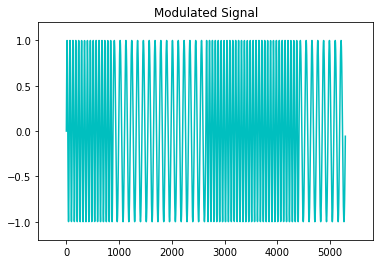

2646.0


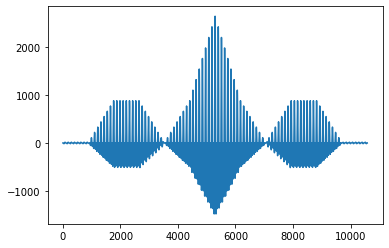

2205.0


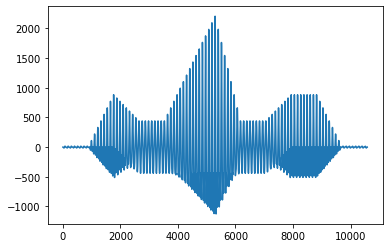

1764.0


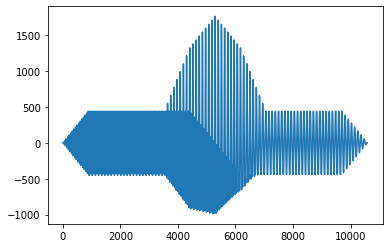

1323.0000000000005


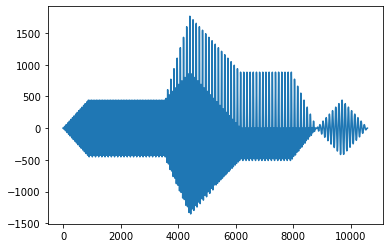

In [7]:
bits = np.array([1,0,0,1,1,0])

tx = fsk(bitseq = bits, spb = samps, f_0 = f0, f_1 = f1, F = fs)
setup_plot("Modulated Signal")
plt.plot(tx, 'c')
plt.show()

rtt = np.correlate(tx, tx, mode ="full")
print(rtt[samps*bits.shape[0]-1])
plt.plot(rtt)
plt.show()


"""plt.plot(tx**2, 'g')
plt.show()
max = np.sum(tx**2)
print(max)"""

#1-bit difference
bits1 = np.array([1,0,0,0,1,0]) 
rx = fsk(bitseq = bits1, spb = samps, f_0 = f0, f_1 = f1, F = fs)

rtr = np.correlate(tx, rx, mode ="full")
print(rtr[samps*bits.shape[0]-1])
plt.plot(rtr)
plt.show()


#2-bit difference
bits1 = np.array([0,0,0,1,1,1]) 
rx = fsk(bitseq = bits1, spb = samps, f_0 = f0, f_1 = f1, F = fs)

rtr = np.correlate(tx, rx, mode ="full")
print(rtr[samps*bits.shape[0]-1])
plt.plot(rtr)
plt.show()


#3-bit difference
bits1 = np.array([0,1,0,1,1,1]) 
rx = fsk(bitseq = bits1, spb = samps, f_0 = f0, f_1 = f1, F = fs)

rtr = np.correlate(tx, rx, mode ="full")
print(rtr[samps*bits.shape[0]-1])
plt.plot(rtr)
plt.show()

#Alternating 1/0 Pattern

**Lengths**
*   12-bit


**Outputs**:
1.   Binary autocorrelation
2.   Binary XNOR logic autocorrelation
3.   FSK modulated signal autocorrelation
4.   Chirped FSK modulated signal autocorrelation

***12-bit Alternating***

12


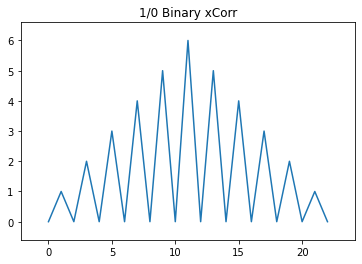

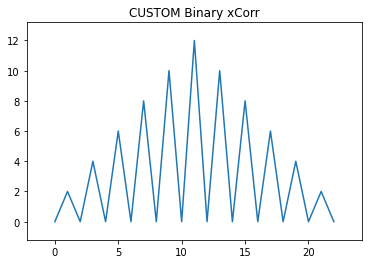

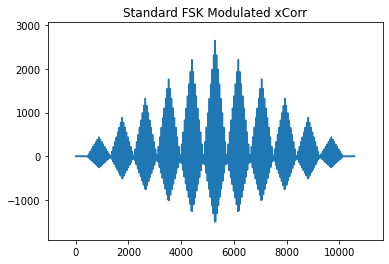

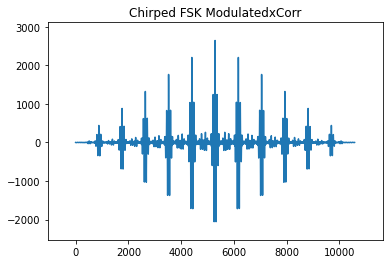

In [8]:
Alternating10 = np.array([1,0,1,0,1,0,1,0,1,0,1,0])
show_corr_outs(Alternating10, f0, f1, fs, samps, dsamp, delta_f)

#BARKER CODES

**Lengths**
*   11-bit
*   13-bit


**Outputs**:
1.   Autocorrelation for mark = 1 and space = -1
2.   Binary autocorrelation
3.   Binary XNOR logic autocorrelation
4.   FSK modulated signal autocorrelation
5.   Chirped FSK modulated signal autocorrelation









***11-bit Barker***

11


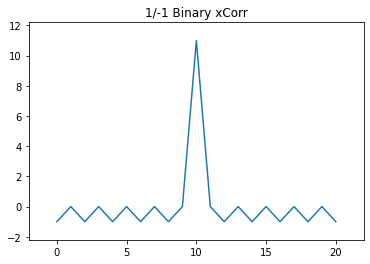

11


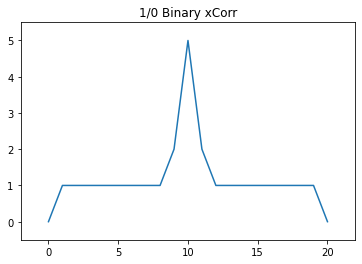

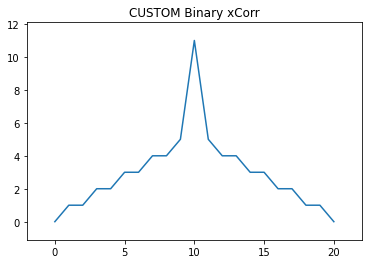

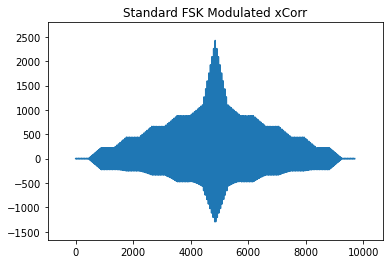

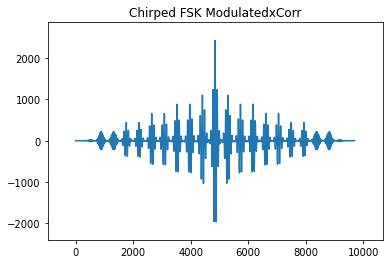

In [9]:
org_Barker11 = np.array([1,1,1,-1,-1,-1,1,-1,-1,1,-1])
print(org_Barker11.shape[0])
rbb = np.correlate(org_Barker11, org_Barker11, mode = "full")
setup_plot("1/-1 Binary xCorr")
plt.plot(rbb)
plt.show()


Barker11 = np.array([1,1,1,0,0,0,1,0,0,1,0])
show_corr_outs(Barker11, f0, f1, fs, samps, dsamp, delta_f)

***13-bit Barker***

13


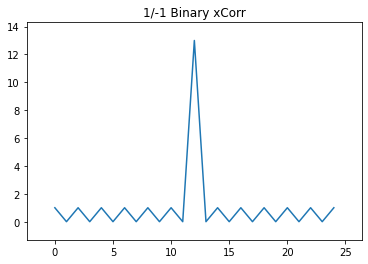

13


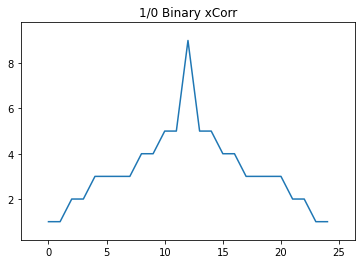

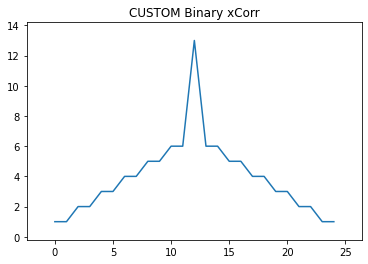

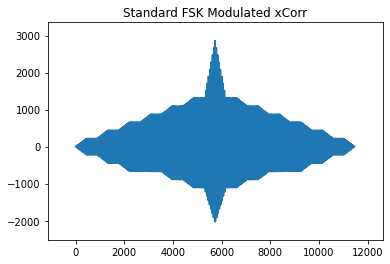

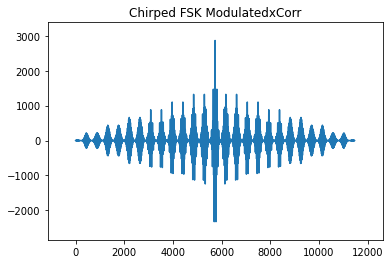

In [10]:
org_Barker13 = np.array([1,1,1,1,1,-1,-1,1,1,-1,1,-1,1])
print(org_Barker13.shape[0])
rbb = np.correlate(org_Barker13, org_Barker13, mode = "full")
setup_plot("1/-1 Binary xCorr")
plt.plot(rbb)
plt.show()

Barker13 = np.array([1,1,1,1,1,0,0,1,1,0,1,0,1])
show_corr_outs(Barker13, f0, f1, fs, samps, dsamp, delta_f)

#Natural Legendre

**Lengths**
* 10-bit (n=11)  
* 12-bit (n=13)

**Outputs**:
1.   Binary autocorrelation
2.   Binary XNOR logic autocorrelation
3.   FSK modulated signal autocorrelation
4.   Chirped FSK modulated signal autocorrelation


***10-bit Legendre***

10


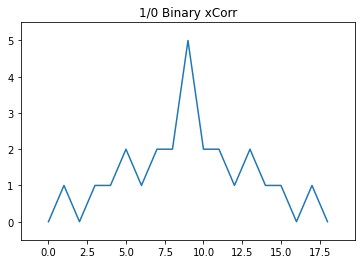

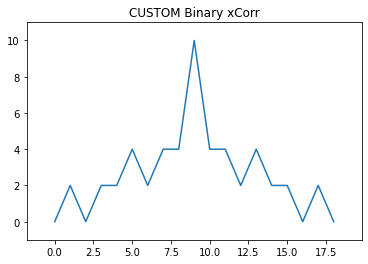

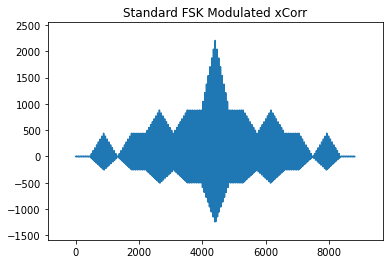

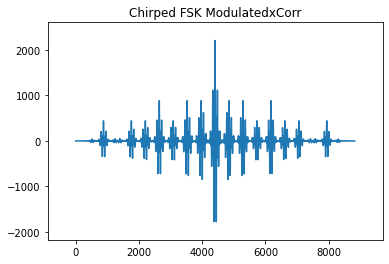

In [11]:
"""
bit = np.array([1, -1, 1, 1, 1, -1, -1, -1, 1, -1])
print(bit.shape[0])
rbb = np.correlate(bit, bit, mode = "full")
setup_plot("1/-1 xCorr")
plt.plot(rbb)
plt.show()
"""

Legendre10 = np.array([1, 0, 1, 1, 1, 0, 0, 0, 1, 0])
show_corr_outs(Legendre10, f0, f1, fs, samps, dsamp, delta_f)

***12-bit Legendre***

12


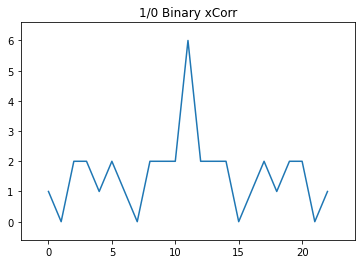

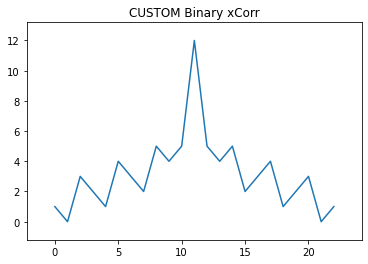

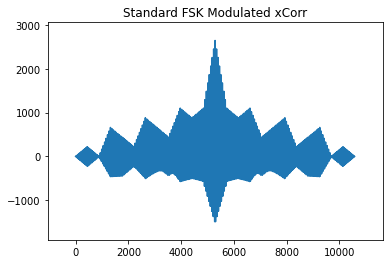

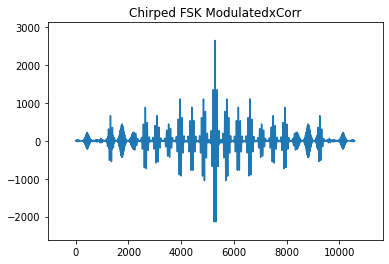

In [12]:
"""bit = np.array([1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1])
print(bit.shape[0])
rbb = np.correlate(bit, bit, mode = "full")
setup_plot("1/-1 xCorr")
plt.plot(rbb)
plt.show()"""

Legendre12 = np.array([1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1])
show_corr_outs(Legendre12, f0, f1, fs, samps, dsamp, delta_f)

#WILLIARD CODES

**Lengths**
*   11-bits
*   12-bits
*   13-bits

**Outputs**:
1.   Binary autocorrelation
2.   Binary XNOR logic autocorrelation
3.   FSK modulated signal autocorrelation
4.   Chirped FSK modulated signal autocorrelation

***11-bit Williard***

11


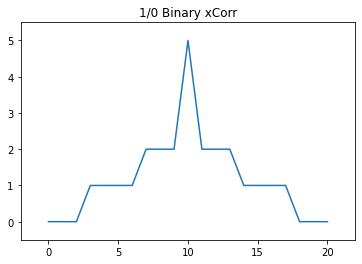

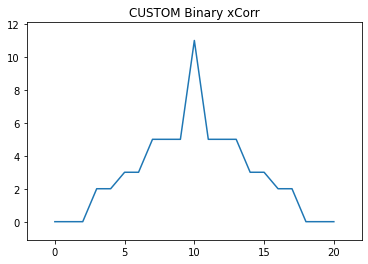

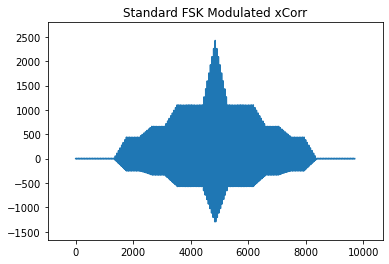

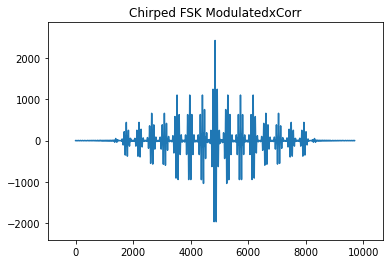

In [13]:
"""bit = np.array([-1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1])
print(bit.shape[0])
rbb = np.correlate(bit, bit, mode = "full")
setup_plot("1/-1 xCorr")
plt.plot(rbb)
plt.show()"""

Williard11 = np.array([0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1])
show_corr_outs(Williard11, f0, f1, fs, samps, dsamp, delta_f)

***12-bit Williard***

12


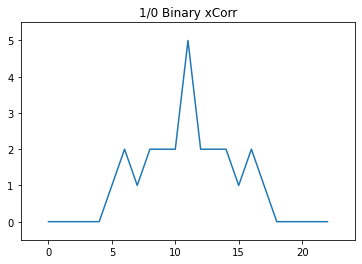

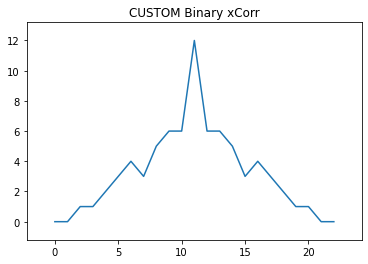

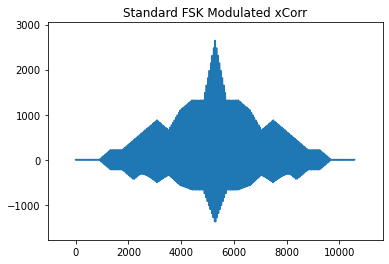

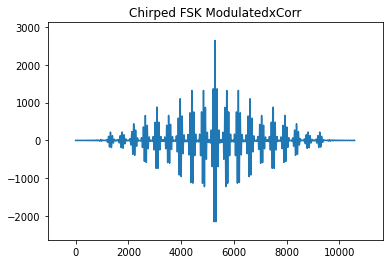

In [14]:
"""bit = np.array([-1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1])
print(bit.shape[0])
rbb = np.correlate(bit, bit, mode = "full")
setup_plot("1/-1 xCorr")
plt.plot(rbb)
plt.show()"""

Williard12 = np.array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1])
show_corr_outs(Williard12, f0, f1, fs, samps, dsamp, delta_f)

***13-bit Williard***

13


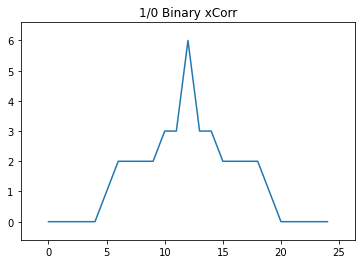

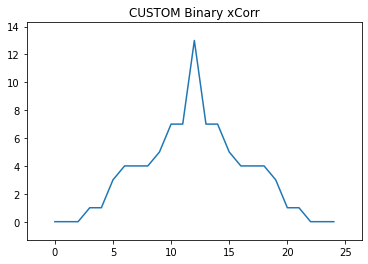

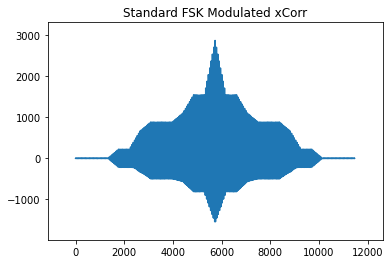

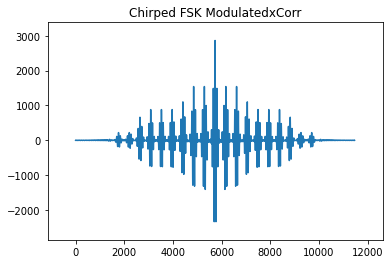

In [15]:
"""bit = np.array([-1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1])
print(bit.shape[0])
rbb = np.correlate(bit, bit, mode = "full")
setup_plot("1/-1 xCorr")
plt.plot(rbb)
plt.show()"""

Williard13 = np.array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1])
show_corr_outs(Williard13, f0, f1, fs, samps, dsamp, delta_f)

#MAURY-STYLES CODES

**Lengths**
*   11-bits
*   12-bits
*   13-bits

**Outputs**:
1.   Binary autocorrelation
2.   Binary XNOR logic autocorrelation
3.   FSK modulated signal autocorrelation
4.   Chirped FSK modulated signal autocorrelation

***11-bit Maury-Styles***

11


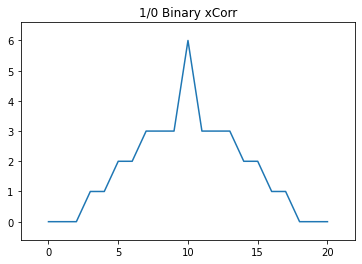

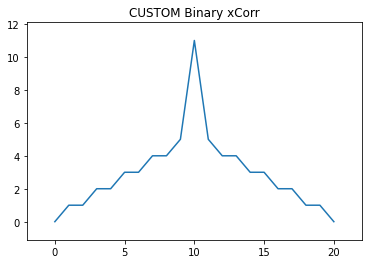

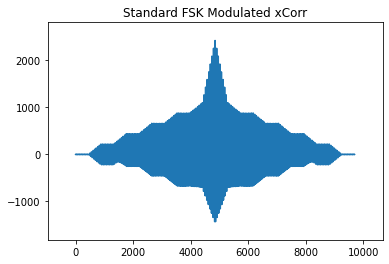

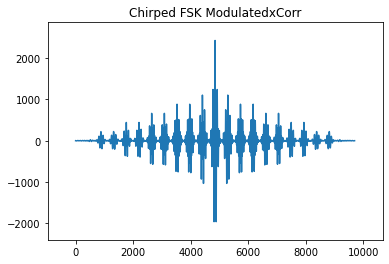

In [16]:
"""bit = np.array([1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1])
print(bit.shape[0])
rbb = np.correlate(bit, bit, mode = "full")
setup_plot("1/-1 xCorr")
plt.plot(rbb)
plt.show()"""

MauryStyles11 = np.array([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0])
show_corr_outs(MauryStyles11, f0, f1, fs, samps, dsamp, delta_f)

***12-bit Maury-Styles***

12


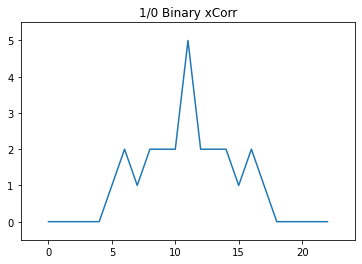

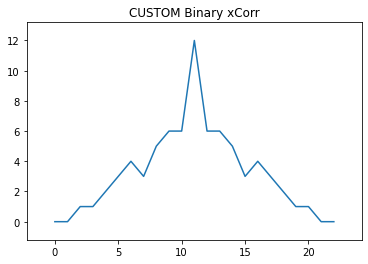

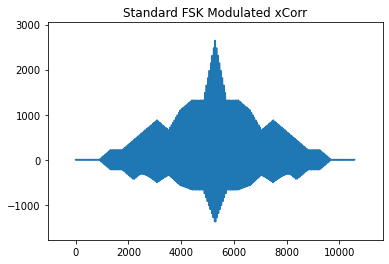

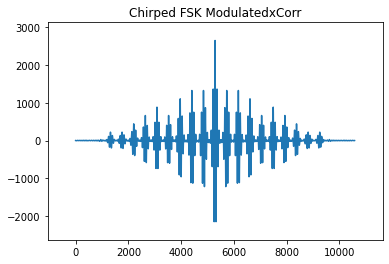

In [17]:
"""bit = np.array([1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1])
print(bit.shape[0])
rbb = np.correlate(bit, bit, mode = "full")
setup_plot("1/-1 xCorr")
plt.plot(rbb)
plt.show()"""

MauryStyles12 = np.array([1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0])
show_corr_outs(MauryStyles12, f0, f1, fs, samps, dsamp, delta_f)

***13-bit Maury-Styles***

13


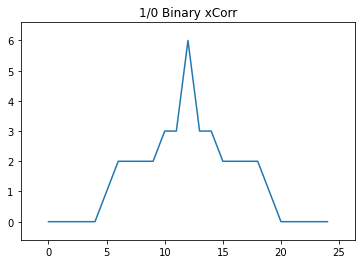

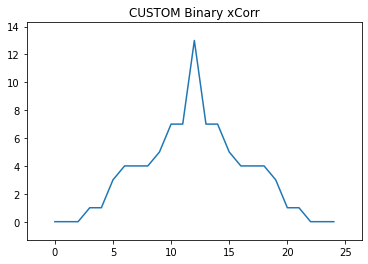

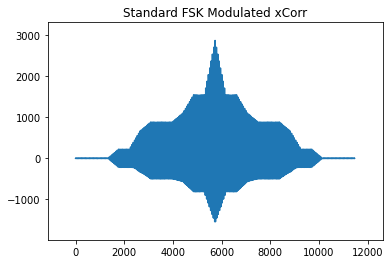

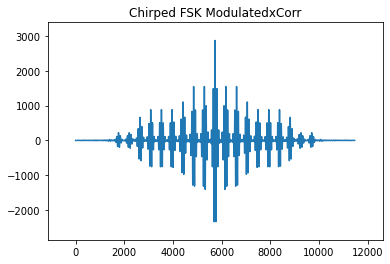

In [18]:
"""bit = np.array([1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1])
print(bit.shape[0])
rbb = np.correlate(bit, bit, mode = "full")
setup_plot("1/-1 xCorr")
plt.plot(rbb)
plt.show()"""

MauryStyles13 = np.array([1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0])
show_corr_outs(MauryStyles13, f0, f1, fs, samps, dsamp, delta_f)

#Optimum 12-bit Binary Codes



1.   Initialize and define
2.   Populate matrix (integer;  peak-to-sidelobe ratio;  binary character;  XNOR correlation)
3.   Sort by siedlobe ratio (SLR)
4.   Delete entries which do not meet defined treshold SLR 
5.   Delete entries with defined no. repeated binary characters
6.   Remove entries within defined Hamming distance



In [19]:
BITS = 12
MAX = 2**BITS
vals = np.array(range(0, MAX))
print(vals)

[   0    1    2 ... 4093 4094 4095]


In [20]:
num = 0
slr = num+1
bit_begin = slr+1
bit_end = bit_begin+BITS
rxx_begin = bit_end+1
rxx_end = rxx_begin + 2*BITS - 1  

print(num, slr, bit_begin, bit_end, rxx_begin, rxx_end)
print()

A = np.zeros( shape = (MAX, rxx_end))

A[:,num] = np.array(range(0, MAX))

A[:, bit_begin:bit_end] = vec_bin_array(arr = vals, m = 12)

for i in vals:
  bin_seq = A[i, bit_begin:bit_end]
  bin_rxx = xnor_autocorr(bin_seq)
  A[i, rxx_begin:rxx_end] = bin_rxx

  max_lobe = bin_rxx[0]
  for k in range(1, BITS-1):
      if bin_rxx[k] > max_lobe:
        max_lobe = bin_rxx[k]

  A[i, slr] =  max_lobe/bin_rxx[BITS-1]

A = A[A[:,slr].argsort()]
print(A[:, num:slr+1])

0 1 2 14 15 38

[[3.24400000e+03 3.33333343e-01]
 [8.51000000e+02 3.33333343e-01]
 [3.17800000e+03 4.16666657e-01]
 ...
 [2.04700000e+03 8.33333313e-01]
 [0.00000000e+00 9.16666687e-01]
 [4.09500000e+03 9.16666687e-01]]


In [21]:
threshold = 5/12 + 0.001
dels = []

for i in range(0, MAX):
  if (A[i, slr] > threshold):
    dels.append(i)

A_minthresh = np.delete(A, obj = np.array(dels), axis = 0)
print(A_minthresh.shape[0])

634


In [22]:
rpt_thresh = 5
dels = []

for i in range(0, A_minthresh.shape[0]):
  rpt = 1
  bfound = 0
  for k in range(bit_begin+1, bit_end):
    if ( int(A_minthresh[i, k]) == int(A_minthresh[i, k-1]) ) and ( bfound == 0 ):
      rpt = rpt +1
    else:
      rpt = 1
    if (rpt >= rpt_thresh):
      bfound = 1
      dels.append(i)

A_rptthresh = np.delete(A_minthresh, obj = np.array(dels), axis = 0)
print(A_rptthresh.shape[0])

print(A_rptthresh[0:10, bit_begin:bit_end])

634
[[1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1.]
 [1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0.]
 [0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0.]
 [0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0.]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  app.launch_new_instance()


In [23]:
"""
A_rptthresh = [[0,0,0,1,1,1,0,0,0,1,1,1],
               [0,0,0,1,1,1,0,0,0,1,1,1],
               [0,0,0,0,1,1,0,0,0,1,1,1],
               [0,0,0,1,1,1,1,0,0,1,1,0],
               [0,1,1,1,0,1,0,0,0,1,1,1],
               [0,0,0,1,1,1,0,0,0,1,1,1]]

A_rptthresh = np.array(A_rptthresh)
bit_begin = 0
bit_end = 12
"""

hamm_thresh = 3
dels = []


bdel = np.zeros( shape = (A_rptthresh.shape[0],) )

for i in range(0, A_rptthresh.shape[0]):
  hamm = np.zeros( shape = (A_rptthresh.shape[0],) )

  for k in range(0, A_rptthresh.shape[0]):
  
    for j in range(bit_begin+1, bit_end):
      if (bdel[i] == 0) and (not (i == k)) and ( int(A_rptthresh[i, j]) == int(A_rptthresh[k, j]) ) :
        hamm[k] = hamm[k] + 1

      if (hamm[k] >= BITS-hamm_thresh-1):
        bdel[k] = 1
        dels.append(k)

A_hammthresh = np.delete(A_rptthresh, obj = np.array(dels), axis = 0)
print(A_hammthresh.shape[0])

print(A_hammthresh[:, bit_begin:bit_end])

23
[[1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0.]
 [1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1.]
 [0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1.]
 [1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1.]
 [1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1.]
 [0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0.]
 [1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1.]
 [0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0.]
 [1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1.]]


3244.0
[1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0.]


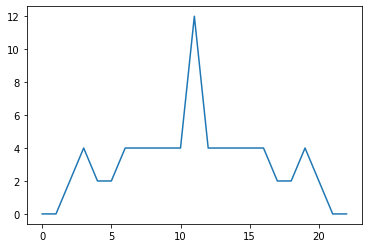

851.0
[0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1.]


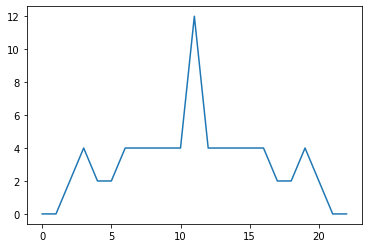

3178.0
[1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0.]


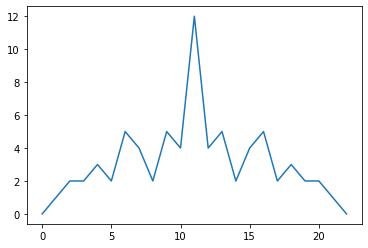

3405.0
[1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1.]


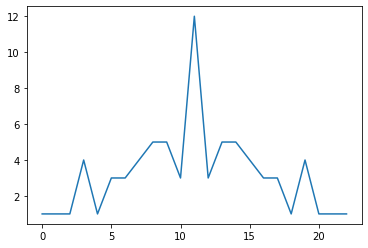

788.0
[0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]


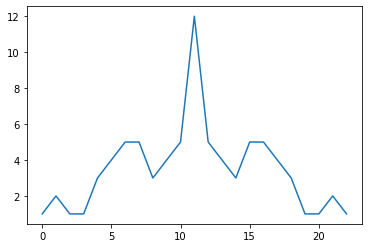

1850.0
[0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0.]


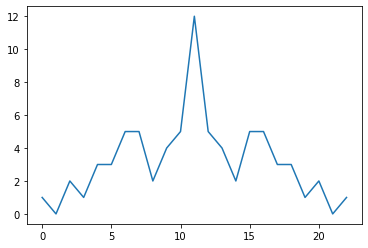

809.0
[0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1.]


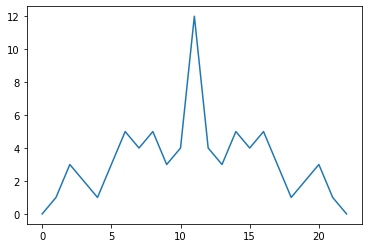

1862.0
[0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0.]


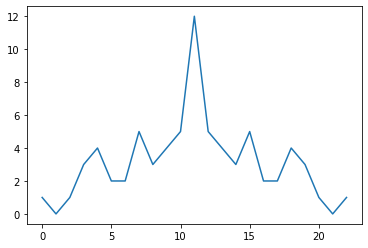

738.0
[0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0.]


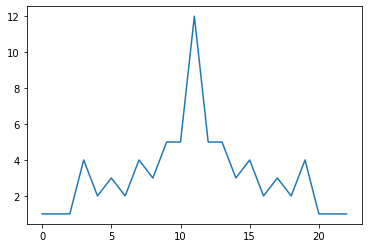

3363.0
[1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1.]


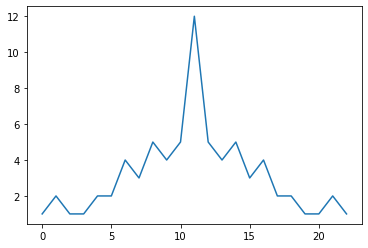

906.0
[0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0.]


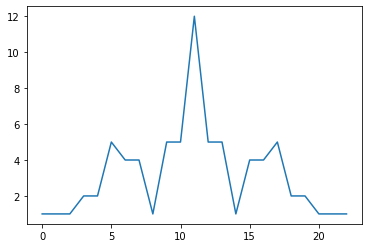

1765.0
[0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1.]


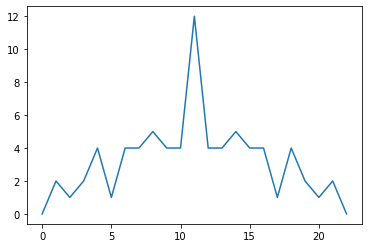

732.0
[0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0.]


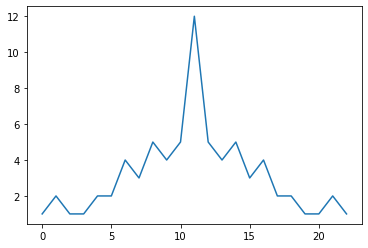

470.0
[0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0.]


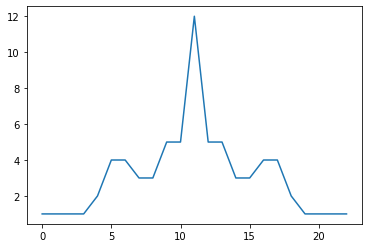

2137.0
[1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1.]


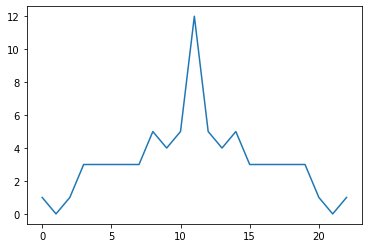

689.0
[0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1.]


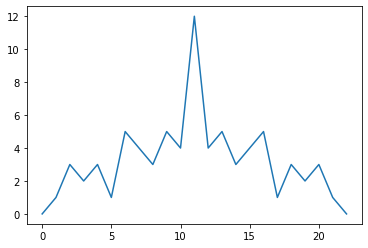

3477.0
[1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1.]


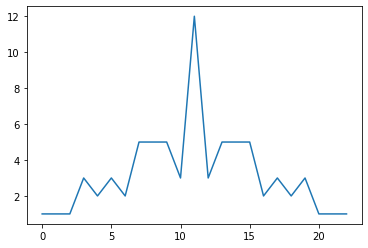

3211.0
[1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1.]


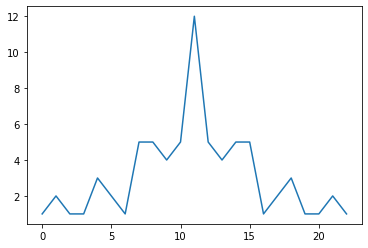

1496.0
[0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0.]


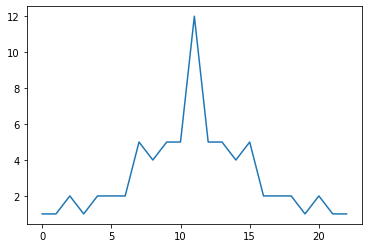

2983.0
[1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1.]


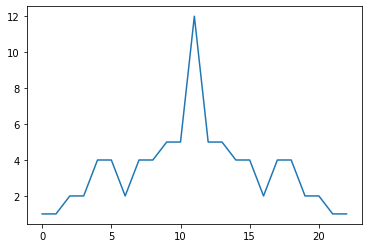

1140.0
[0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0.]


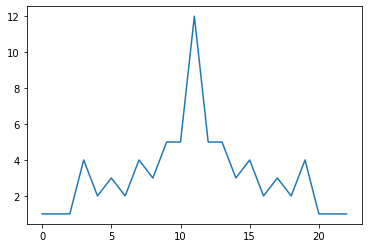

302.0
[0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0.]


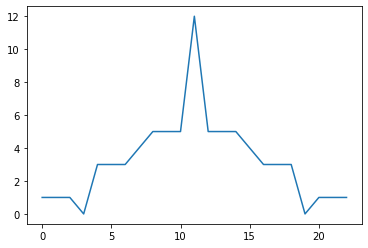

2539.0
[1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1.]


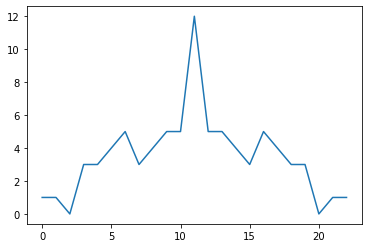

In [24]:
B = A_hammthresh

for i in range(0, B.shape[0]):
  bits = B[i, bit_begin:bit_end]
  rbb = xnor_autocorr(bits)
  print(B[i, num])
  print(bits)
  plt.plot(rbb)
  plt.show()


#############
1 3
5
4410.0


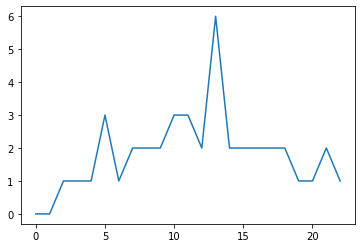

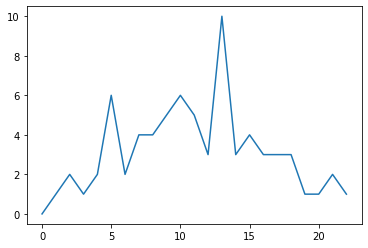

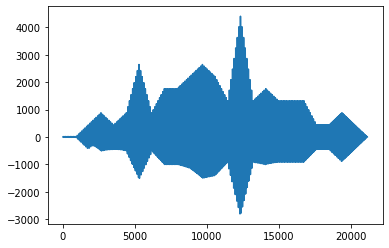

#############
3 1
5
4410.0


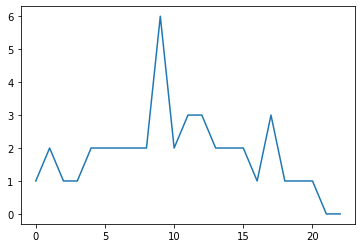

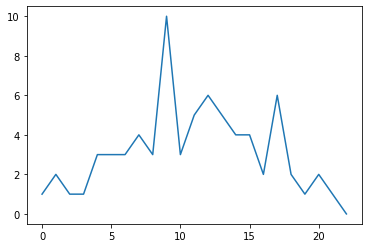

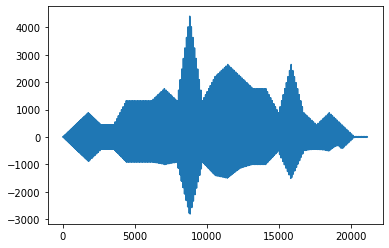

#############
7 19
6
4410.0


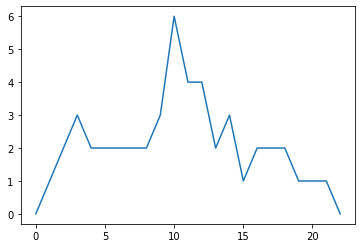

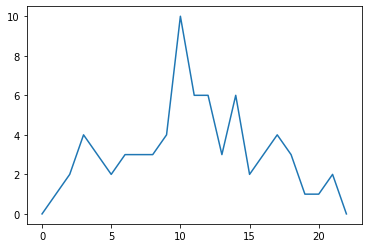

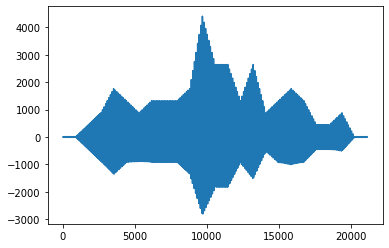

#############
11 22
5
3969.0


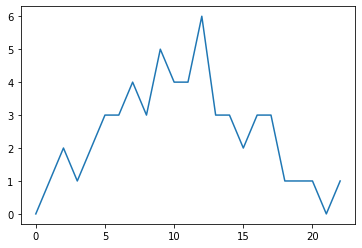

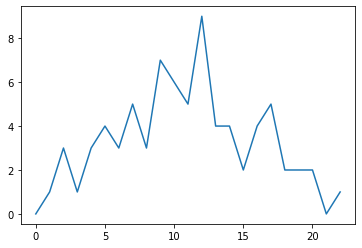

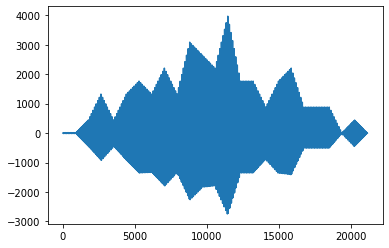

#############
13 22
6
4410.0


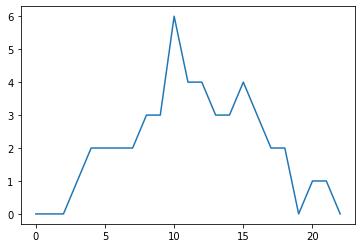

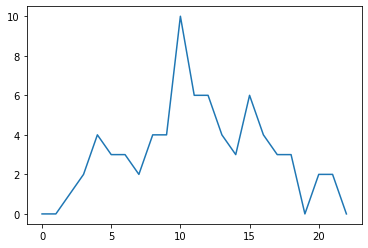

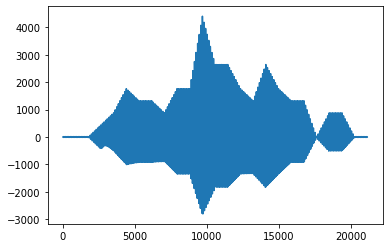

#############
19 7
6
4410.0


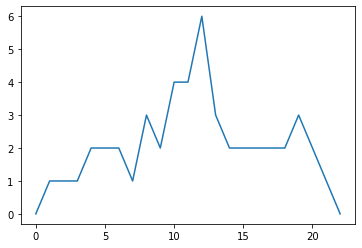

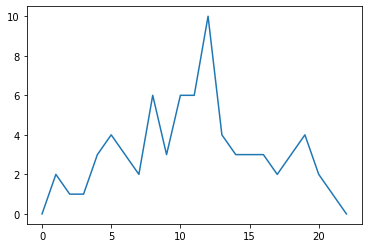

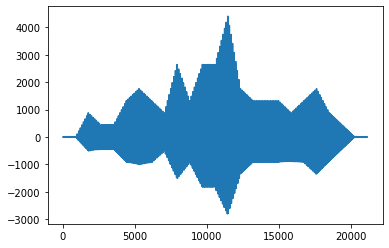

#############
19 22
8
3528.0


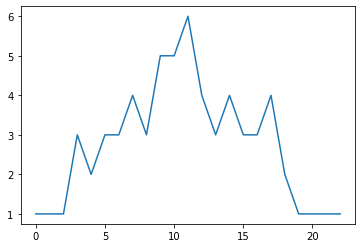

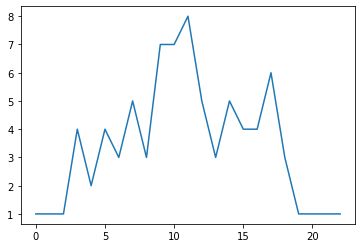

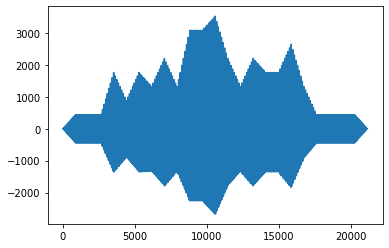

#############
22 11
5
3969.0


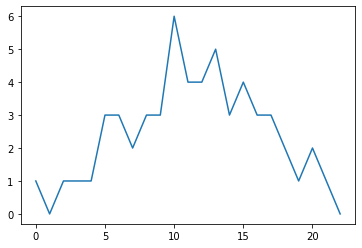

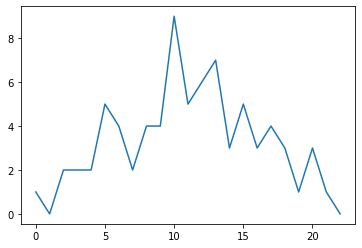

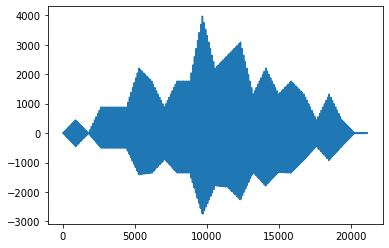

#############
22 13
6
4410.0


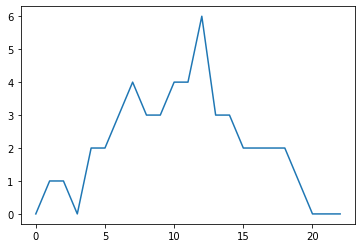

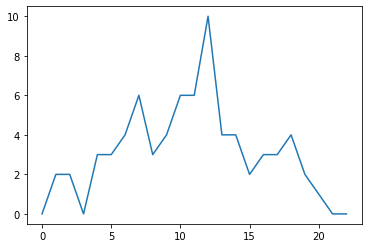

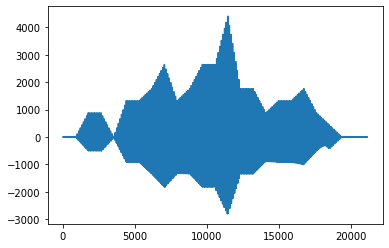

#############
22 19
8
3528.0


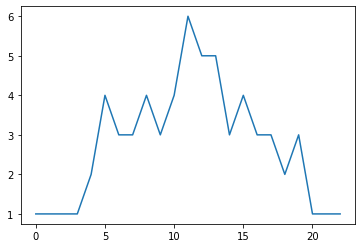

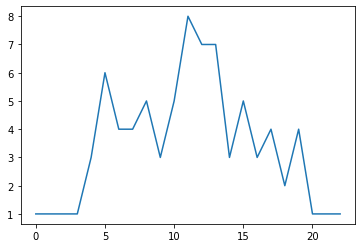

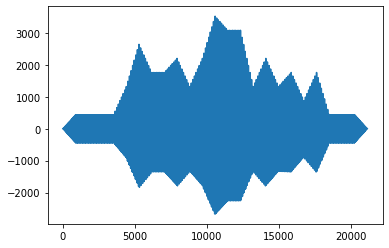

In [136]:
for i in range(0, B.shape[0]):
  bitseq1 = B[i, bit_begin:bit_end]
  
  for k in range(0, B.shape[0]):
    bitseq2 = B[k, bit_begin:bit_end]
    
    if not (i == k):
      
      rik = np.correlate(bitseq1, bitseq2, mode = "full")
      rik1 = xnor_xcorr(bitseq1, bitseq2)
      
      for j in range(0, rik.shape[0]):
        
        if (rik[ j ] >= 6):

          fsk1 = fsk(bitseq1, samps, f0, f1, fs)
          fsk2 = fsk(bitseq2, samps, f0, f1, fs)

          r12 = np.correlate(fsk1, fsk2, mode = "full")

          hamm = 0
          for j in range(0, bitseq1.shape[0]):
            if ( bitseq1[j] == bitseq2[j] ) :
                hamm = hamm + 1

          print("#############")

          print(i, k)
          print(hamm)
          print( round(np.max(r12) ) )
          
          plt.plot(rik)
          plt.show()

          plt.plot(rik1)
          plt.show()

          plt.plot(r12)         
          plt.show()

**Check FSK AutoCorr of some codes**

[1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


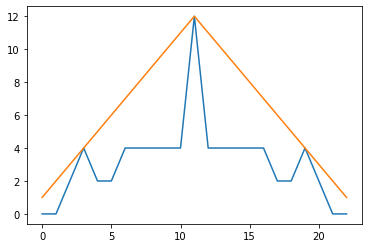

[1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0.]
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


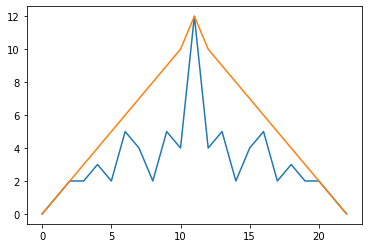

[0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1.]
[0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.]


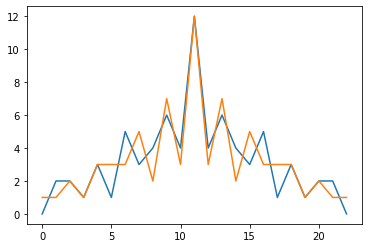

In [ ]:
print( A[   0   , bit_begin:bit_end] )
print( A[ MAX-1 , bit_begin:bit_end] )

plt.plot( A[   0   , rxx_begin:rxx_end] )
plt.plot( A[ MAX-1 , rxx_begin:rxx_end] )
plt.show()


print( A[   2   , bit_begin:bit_end] )
print( A[ MAX-3 , bit_begin:bit_end] )

plt.plot( A[   2   , rxx_begin:rxx_end] )
plt.plot( A[ MAX-3 , rxx_begin:rxx_end] )
plt.show()


print( A[  int(MAX/4)  , bit_begin:bit_end] )
print( A[ int(3*MAX/4) , bit_begin:bit_end] )

plt.plot( A[  int(MAX/4)  , rxx_begin:rxx_end] )
plt.plot( A[ int(3*MAX/4) , rxx_begin:rxx_end] )
plt.show()

12


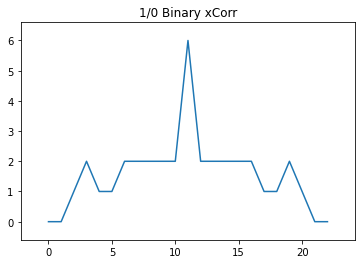

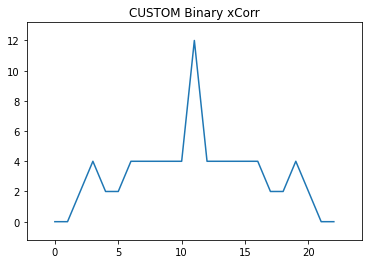

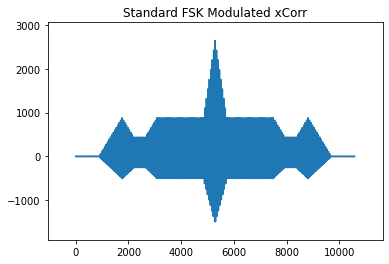

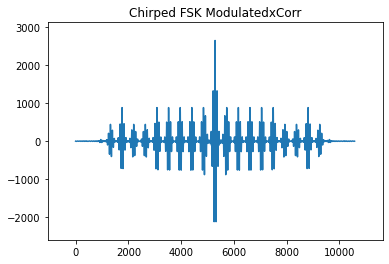

In [ ]:
show_corr_outs( A[   0   , bit_begin:bit_end] , f0, f1, fs, samps, dsamp, delta_f)

12


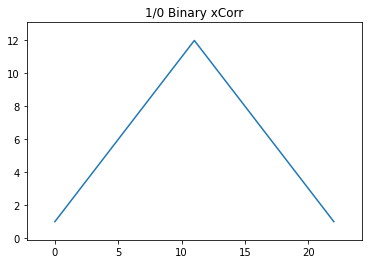

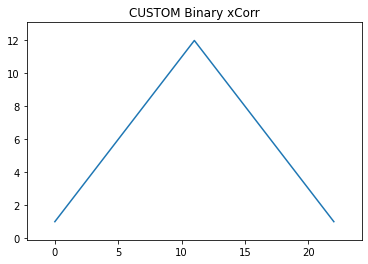

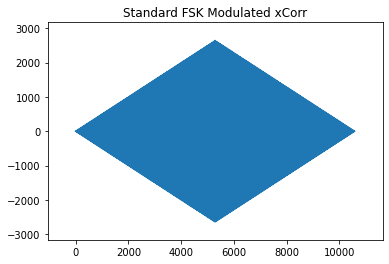

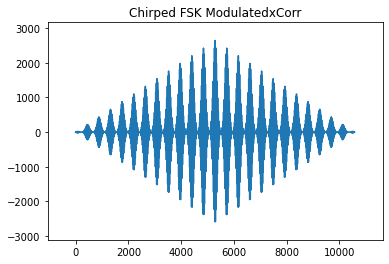

In [ ]:
show_corr_outs( A[ MAX-1 , bit_begin:bit_end] , f0, f1, fs, samps, dsamp, delta_f)

12


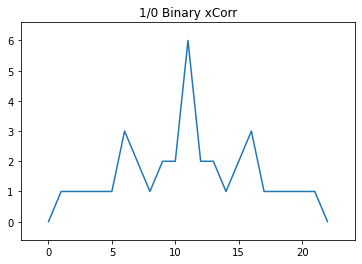

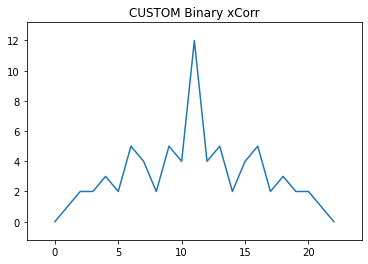

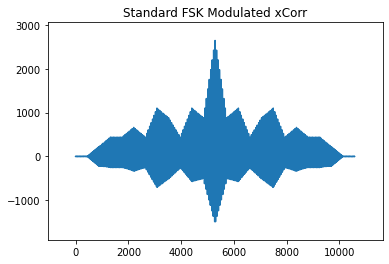

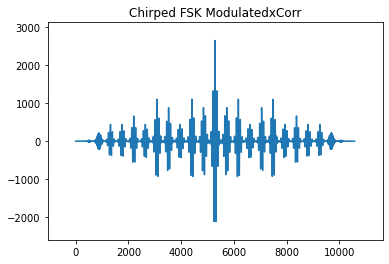

In [ ]:
show_corr_outs( A[   2   , bit_begin:bit_end] , f0, f1, fs, samps, dsamp, delta_f)

12


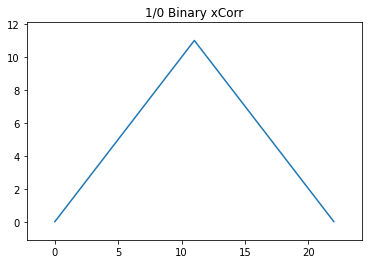

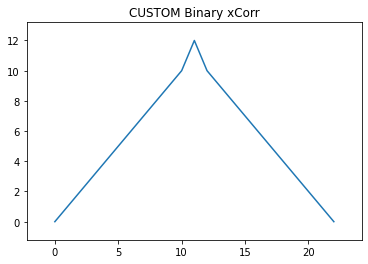

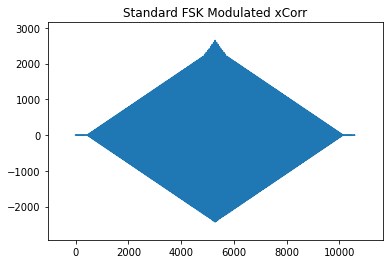

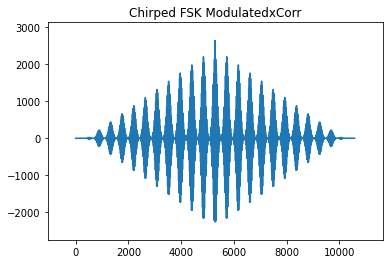

In [ ]:
show_corr_outs( A[ MAX-3 , bit_begin:bit_end] , f0, f1, fs, samps, dsamp, delta_f)